# Imports & Path Setup

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Import reusable training & tuning utilities
from src.models.train import train_and_evaluate, fit_full_model, save_results
from src.models.tune import tune_model

# Load Data

In [2]:
# Load the processed dataset
df = pd.read_csv("../data/processed/merged_clean_refined.csv")

target_col = "DeclineFlag"
group_col = "player_id"

# Ensure grouping column exists
if "player_id" not in df.columns:
    df["player_id"] = df.index

feature_cols = [c for c in df.columns if c not in [target_col, group_col]]

X = df[feature_cols]
y = df[target_col]
groups = df[group_col]

print("Dataset shape:", X.shape)
print("Target distribution:\n", y.value_counts(normalize=True).round(3))


Dataset shape: (4829, 19)
Target distribution:
 DeclineFlag
0.0    0.608
1.0    0.392
Name: proportion, dtype: float64


# Cross-Validation & Scoring Setup

In [3]:
from sklearn.metrics import make_scorer

cv = GroupKFold(n_splits=5)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

print("Cross-validation strategy:", cv)


Cross-validation strategy: GroupKFold(n_splits=5)


# Define Preprocessing Pipeline

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


# RandomForest Tuning

In [5]:
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    "model__n_estimators": [100, 300, 500],
    "model__max_depth": [5, 10, 20, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2"]
}

best_rf, rf_results = tune_model(
    model=pipeline_rf,
    param_grid=rf_param_grid,
    X=X,
    y=y,
    groups=groups,
    cv=cv,
    scoring=scoring,
    search_type="random",
    n_iter=25,
    refit_metric="f1",
    save_results_path="../results/rf_tuning_results.csv",
    save_model_path="../artifacts/RandomForest_tuned_pipeline.joblib"
)



🔍 Starting RandomSearchCV for Pipeline
→ Optimizing for metric: 'f1'
Fitting 5 folds for each of 25 candidates, totalling 125 fits

✅ Best Parameters Found:
   model__n_estimators: 300
   model__min_samples_split: 2
   model__min_samples_leaf: 1
   model__max_features: log2
   model__max_depth: None

Best F1: 0.6933

📄 Saved CV results to: ../results/rf_tuning_results.csv
💾 Saved best model to: ../artifacts/RandomForest_tuned_pipeline.joblib


# XGBoost Tuning

In [8]:
from xgboost import XGBClassifier

pipeline_xgb = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        random_state=42,
        eval_metric="logloss",
        use_label_encoder=False
    ))
])

xgb_param_grid = {
    "model__n_estimators": [200, 400],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 5, 7],
    "model__subsample": [0.7, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.9, 1.0]
}

best_xgb, xgb_results = tune_model(
    model=pipeline_xgb,
    param_grid=xgb_param_grid,
    X=X,
    y=y,
    groups=groups,
    cv=cv,
    scoring=scoring,
    search_type="random",
    n_iter=20,
    refit_metric="f1",
    save_results_path="../results/xgb_tuning_results.csv",
    save_model_path="../artifacts/XGBoost_tuned_pipeline.joblib"
)


🔍 Starting RandomSearchCV for Pipeline
→ Optimizing for metric: 'f1'
Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Pouya\Desktop\ON Research\DSBootcampP1\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:46:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Best Parameters Found:
   model__subsample: 0.7
   model__n_estimators: 400
   model__max_depth: 7
   model__learning_rate: 0.1
   model__colsample_bytree: 0.7

Best F1: 0.7877

📄 Saved CV results to: ../results/xgb_tuning_results.csv
💾 Saved best model to: ../artifacts/XGBoost_tuned_pipeline.joblib


# LightGBM Tuning

In [9]:
from lightgbm import LGBMClassifier

pipeline_lgb = Pipeline([
    ("preprocess", preprocessor),
    ("model", LGBMClassifier(random_state=42))
])

lgb_param_grid = {
    "model__n_estimators": [200, 400, 600],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__num_leaves": [31, 63, 127],
    "model__max_depth": [-1, 5, 10],
    "model__subsample": [0.7, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.9, 1.0]
}

best_lgb, lgb_results = tune_model(
    model=pipeline_lgb,
    param_grid=lgb_param_grid,
    X=X,
    y=y,
    groups=groups,
    cv=cv,
    scoring=scoring,
    search_type="random",
    n_iter=20,
    refit_metric="f1",
    save_results_path="../results/lgb_tuning_results.csv",
    save_model_path="../artifacts/LightGBM_tuned_pipeline.joblib"
)



🔍 Starting RandomSearchCV for Pipeline
→ Optimizing for metric: 'f1'
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 1892, number of negative: 2937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1458
[LightGBM] [Info] Number of data points in the train set: 4829, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391800 -> initscore=-0.439754
[LightGBM] [Info] Start training from score -0.439754

✅ Best Parameters Found:
   model__subsample: 0.7
   model__num_leaves: 31
   model__n_estimators: 600
   model__max_depth: -1
   model__learning_rate: 0.05
   model__colsample_bytree: 0.9

Best F1: 0.7901

📄 Saved CV results to: ../results/lgb_tuning_results.csv
💾 Saved best model to: ../artifacts/LightGBM_tuned_pipeline.joblib


# Combine and Compare Tuned Results

In [10]:
rf_summary = rf_results[["params", "mean_test_f1", "mean_test_roc_auc"]].head(1)
xgb_summary = xgb_results[["params", "mean_test_f1", "mean_test_roc_auc"]].head(1)
lgb_summary = lgb_results[["params", "mean_test_f1", "mean_test_roc_auc"]].head(1)

comparison_df = pd.DataFrame({
    "model": ["RandomForest", "XGBoost", "LightGBM"],
    "f1": [rf_summary["mean_test_f1"].values[0],
           xgb_summary["mean_test_f1"].values[0],
           lgb_summary["mean_test_f1"].values[0]],
    "roc_auc": [rf_summary["mean_test_roc_auc"].values[0],
                xgb_summary["mean_test_roc_auc"].values[0],
                lgb_summary["mean_test_roc_auc"].values[0]]
})

comparison_df = comparison_df.sort_values("f1", ascending=False)
print("Tuned Model Comparison:\n")
print(comparison_df)

save_results(comparison_df, "../results/model_comparison_tuned.csv")


Tuned Model Comparison:

          model        f1   roc_auc
2      LightGBM  0.790113  0.902636
1       XGBoost  0.787698  0.902950
0  RandomForest  0.693291  0.880600
📊 Results saved to ../results/model_comparison_tuned.csv


# Visualize Tuned Model Performance

C:\Users\Pouya\AppData\Local\Temp\ipykernel_21648\2440418353.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x="model", y="f1", palette="viridis")


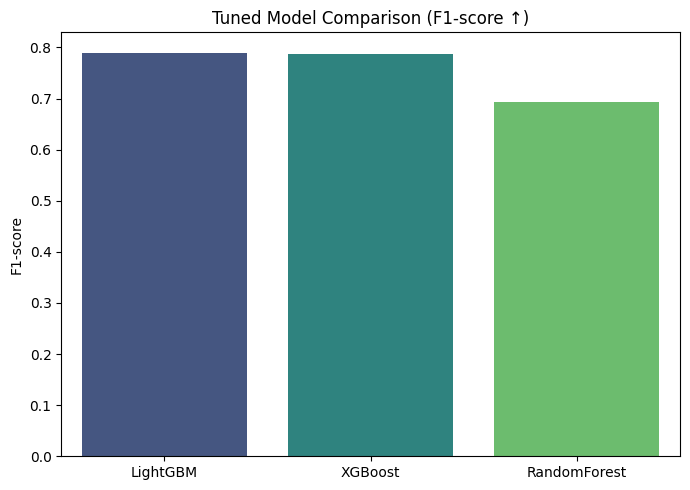

In [11]:
plt.figure(figsize=(7, 5))
sns.barplot(data=comparison_df, x="model", y="f1", palette="viridis")
plt.title("Tuned Model Comparison (F1-score ↑)")
plt.ylabel("F1-score")
plt.xlabel("")
plt.tight_layout()
plt.show()


# Train Best Model on Full Dataset

In [12]:
best_model_name = comparison_df.iloc[0]["model"]

if best_model_name == "RandomForest":
    best_final = best_rf
    model_path = "../artifacts/RandomForest_final.joblib"
elif best_model_name == "XGBoost":
    best_final = best_xgb
    model_path = "../artifacts/XGBoost_final.joblib"
else:
    best_final = best_lgb
    model_path = "../artifacts/LightGBM_final.joblib"

fit_full_model(best_final, X, y, save_path=model_path, model_name=best_model_name)



🚀 Fitting final model on full data: LightGBM
[LightGBM] [Info] Number of positive: 1892, number of negative: 2937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1458
[LightGBM] [Info] Number of data points in the train set: 4829, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391800 -> initscore=-0.439754
[LightGBM] [Info] Start training from score -0.439754
💾 Model saved to: ../artifacts/LightGBM_final.joblib


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['GA90_pre', 'GA_pre',
                                                   'PreMinutes', 'transfer_fee',
                                                   'market_value_in_eur',
                                                   'market_value_in_eur_player',
                                                   'highest_market_value_in_eur',
                                                   'height_in_cm']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImp...')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['from_league', 'to_league',
                                                   'Position', 'sub_position',
                                                   'position', 'foot',
                                                   'country_of_birth',
                                                   'country_of_citizenship',
                                                   'transfer_date',
                                                   'date_of_birth',
                                                   'contract_expiration_date'])])),
                ('model',
                 LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05,
                                n_estimators=600, random_state=42,
                                subsample=0.7))])

# Interpretability (SHAP / Feature Importances)

Generating interpretability plots for: LightGBM


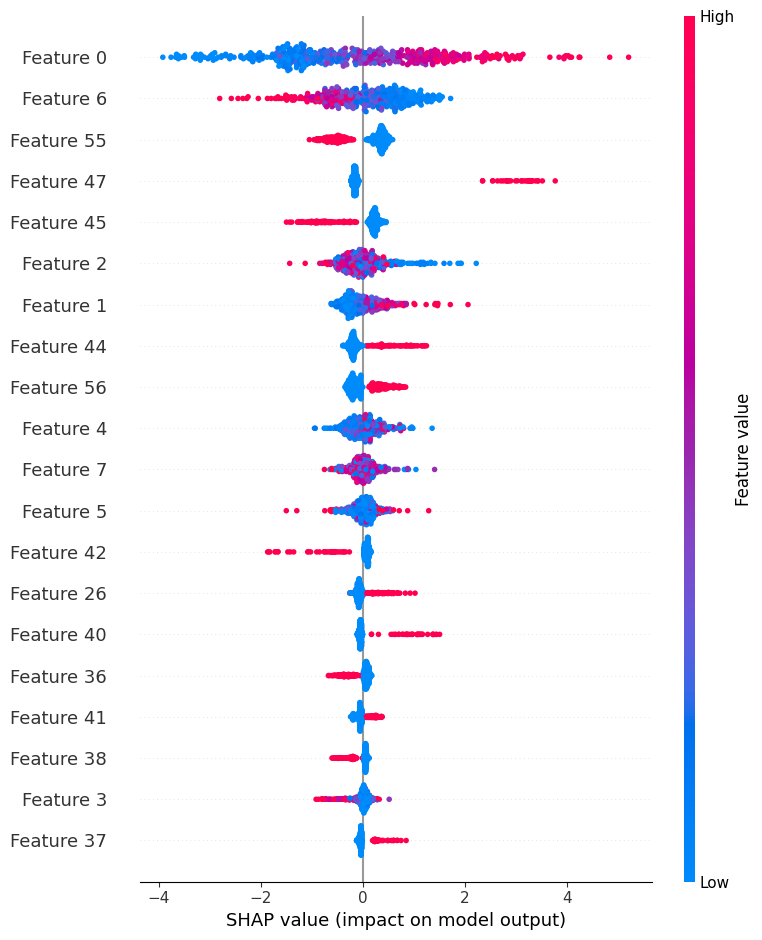

✅ SHAP summary plot generated successfully.


In [15]:
import shap
import numpy as np

print(f"Generating interpretability plots for: {best_model_name}")

# Extract inner model
inner_model = best_final.named_steps["model"]

# Prepare sample data
X_sample = X.sample(n=min(500, len(X)), random_state=42)

# Apply preprocessing
X_transformed = best_final.named_steps["preprocess"].transform(X_sample)

# Convert sparse matrix (from OneHotEncoder) to dense for SHAP
if not isinstance(X_transformed, np.ndarray):
    X_transformed = X_transformed.toarray()

# Try to generate SHAP explanations
try:
    explainer = shap.Explainer(inner_model)
    shap_values = explainer(X_transformed)
    shap.summary_plot(shap_values, X_transformed, show=True)
    print("✅ SHAP summary plot generated successfully.")

except Exception as e:
    print("⚠️ SHAP failed, falling back to feature importance.")
    print(f"Error: {e}")

    # Retrieve encoded feature names
    cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
    num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()
    encoder = best_final.named_steps["preprocess"].named_transformers_["cat"].named_steps["encoder"]
    encoded_cat_features = encoder.get_feature_names_out(cat_cols)
    all_features = np.concatenate([num_cols, encoded_cat_features])

    # Use feature_importances_ as fallback
    if hasattr(inner_model, "feature_importances_"):
        imp_df = pd.DataFrame({
            "feature": all_features,
            "importance": inner_model.feature_importances_
        }).sort_values("importance", ascending=False)
        
        plt.figure(figsize=(8, 6))
        sns.barplot(data=imp_df.head(10), x="importance", y="feature", palette="magma")
        plt.title(f"Top 10 Feature Importances - {best_model_name}")
        plt.tight_layout()
        plt.show()
        print("✅ Feature importance plot shown as fallback.")
    else:
        print("⚠️ Model does not support feature_importances_.")


# Final Summary

In [16]:
print("===== Final Tuned Model Summary =====")
print(comparison_df.to_string(index=False))
print("\nBest model:", best_model_name)
print(f"Model saved at: {model_path}")

===== Final Tuned Model Summary =====
       model       f1  roc_auc
    LightGBM 0.790113 0.902636
     XGBoost 0.787698 0.902950
RandomForest 0.693291 0.880600

Best model: LightGBM
Model saved at: ../artifacts/LightGBM_final.joblib
